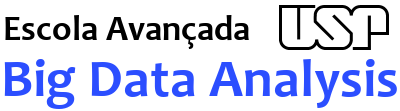

Wasserstein Generative Adversarial Networks - MNIST

In [1]:
!pip uninstall tensorflow keras tensorstore tf-keras orbax-checkpoint -y
!pip install keras==2.15.0 tensorflow==2.15.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
Found existing installation: tensorstore 0.1.68
Uninstalling tensorstore-0.1.68:
  Successfully uninstalled tensorstore-0.1.68
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
Found existing installation: orbax-checkpoint 0.6.4
Uninstalling orbax-checkpoint-0.6.4:
  Successfully uninstalled orbax-checkpoint-0.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.3 MB/s eta 0

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__) # Use __version__ to access version in TensorFlow 2.x and above

import keras
print("Keras version:", keras.__version__) # Use __version__ for Keras as well

import sys
print("Python version:", sys.version)

TensorFlow version: 2.15.0
Keras version: 2.15.0
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [3]:
# Bibliotecas
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras import backend
from keras.constraints import Constraint
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import RMSprop

In [4]:
# Implementacao do Wasserstein Loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [5]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

**Leaky ReLu**

Leaky Rectified Linear Unit, ou Leaky ReLU, é um tipo de função de ativação baseada em uma ReLU, mas tem uma pequena inclinação para valores negativos em vez de uma inclinação plana. O coeficiente de inclinação é determinado antes do treinamento, ou seja, não é aprendido durante o treinamento. Esse tipo de função de ativação é popular em tarefas nas quais podemos sofrer de gradientes esparsos, por exemplo, treinando redes adversárias generativas.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_3.09.45_PM.png" height=250 width=250>

**Conjunto de Dados MNIST**

11490434/11490434 [==============================] - 0s 0us/step


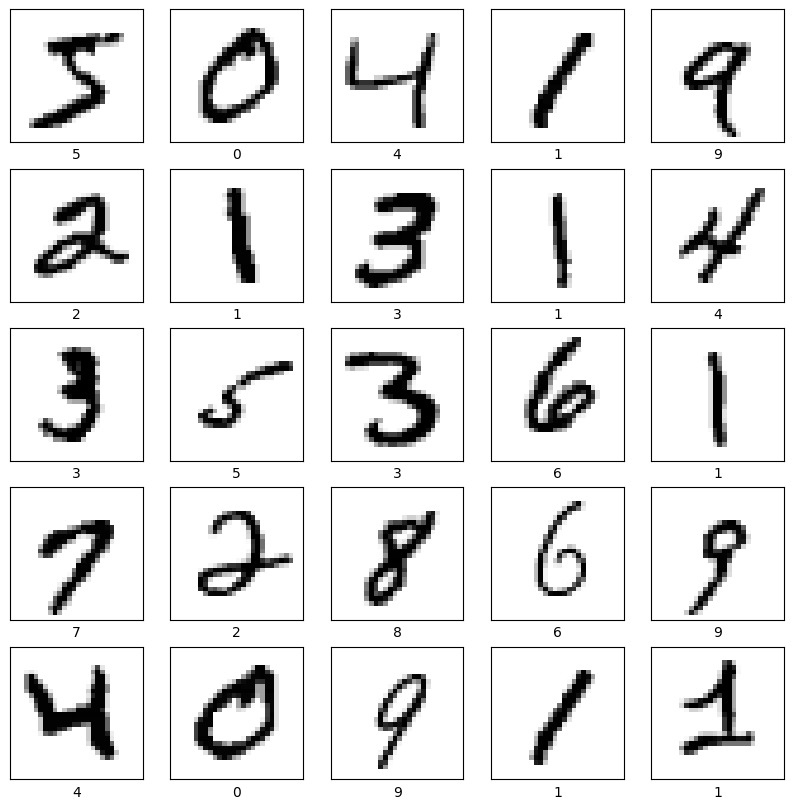

In [6]:
# Conjunto de Dados MNIST
(X_train, y_train), (_, _) = mnist.load_data()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap='binary')
    plt.xlabel(y_train[i])

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
X_train[1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         54, 227, 253, 252, 239, 233, 252,  57,   6,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,  60,
        224, 252, 253, 252, 202,  84, 252, 253, 122,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 163, 252,
        252, 252, 253, 252, 252,  96, 189, 253, 167,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 238, 253,
        253, 190, 114, 253, 228,  47,  79, 255, 168,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238, 252, 252,
        179,  12,  75, 121,  21,   0,   0, 253, 243,  50,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  38, 165, 253, 233, 208,
         84,   0,   0,   0,   0,   0,   0, 253, 252, 165,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   7, 178, 252, 240,  71,  19,
         28,   0,   0,   0,   0,   0,   0, 253, 252, 195,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57, 252, 252,  63,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 252, 195,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 198, 253, 190,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 255, 253, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  76, 246, 252, 112,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 252, 148,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 230,  25,   0,   0,   0,
          0,   0,   0,   0,   0,   7, 135, 253, 186,  12,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 223,   0,   0,   0,   0,
          0,   0,   0,   0,   7, 131, 252, 225,  71,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 145,   0,   0,   0,   0,
          0,   0,   0,  48, 165, 252, 173,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  86, 253, 225,   0,   0,   0,   0,
          0,   0, 114, 238, 253, 162,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 249, 146,  48,  29,  85,
        178, 225, 253, 223, 167,  56,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  85, 252, 252, 252, 229, 215, 252,
        252, 252, 196, 130,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  28, 199, 252, 252, 253, 252, 252,
        233, 145,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  25, 128, 252, 253, 252, 141,
         37,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   

In [9]:
# Dimensões das imagens
img_rows = 28
img_cols = 28
canais = 1
img_shape = (img_rows,img_cols,canais)

In [10]:
np.prod(img_shape)

784

In [11]:
# Gerador
# Receber um vetor latente (ruído) e produzir uma imagem
def constroi_gerador():

  ruido_shape = (100,) # Array de tamanho 100

  # Camadas
  model = Sequential()
  model.add(Input(shape=ruido_shape))

  model.add(Dense(256, activation="LeakyReLU"))
  model.add(BatchNormalization())

  model.add(Dense(512, activation="LeakyReLU"))
  model.add(BatchNormalization())

  model.add(Dense(1024, activation="LeakyReLU"))
  model.add(BatchNormalization())

  # np.prod(img_shape) -> produtos dos valores em img_shape
  model.add(Dense(np.prod(img_shape), activation="LeakyReLU"))
  model.add(Reshape(img_shape)) # reshape para (28 x 28 x 1)

  model.summary()

  noise = Input(shape=ruido_shape)
  img = model(noise) # Imagem gerada

  return Model(noise,img)

In [12]:
constroi_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4

In [13]:
# Critico -> Retorna um score
def constroi_critico():

  # Restrição dos pesos
  const = ClipConstraint(0.01)

  model = Sequential()

  model.add(Input(shape=img_shape))

  model.add(Flatten())

  model.add(Dense(512, activation="LeakyReLU", kernel_constraint=const)) # Restringe pesos

  model.add(Dense(256, activation="LeakyReLU", kernel_constraint=const)) # Restringe pesos

  model.add(Dense(1, activation="linear")) # Na GAN convencional era sigmoid

  model.summary()

  img = Input(shape=img_shape)
  classe = model(img)

  return Model(img,classe)

In [14]:
constroi_critico()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Compilar o gerador

# Critico
critico = constroi_critico()
critico.compile(loss=wasserstein_loss,
                      optimizer=RMSprop(learning_rate=0.00005),
                      metrics=['accuracy'])

# Gerador
gerador = constroi_gerador()
#gerador.compile(loss='binary_crossentropy',
                #optimizer="Adam")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

In [16]:
# Treinamento
def treinamento(epocas, batch_size=128, save_interval=100, n_critic=5):

  # Carregar e processar os dados
  # ----------------------------------------
  (X_train, _), (_, _) = mnist.load_data()

  # Converter para (-1,1)
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5

  # Adicionar a profundidade (1 canal)
  X_train = np.expand_dims(X_train, axis=3)

  # Metade de um batch
  meio_batch = int(batch_size / 2)
  # ----------------------------------------

  # Para cada época
  for epoca in range(epocas):

    # Pega os dados e treina o critico
    # Metade real e metade falso

    # ----------------------
    # Treina o critico critic vezes
    # ----------------------
    for _ in range(n_critic):
        # Pega imagens reais aleatoriamente
        idx = np.random.randint(0, X_train.shape[0], meio_batch)
        imgs = X_train[idx]

        # Gera ruído
        ruido = np.random.normal(0,1,(meio_batch,100))

        # Gera imagens falsas
        gen_imgs = gerador.predict(ruido)

        # Treina o critico nas imagens reais e falsas
        d_erro_real = critico.train_on_batch(imgs, np.ones((meio_batch,1)),return_dict=True)
        d_erro_fake = critico.train_on_batch(gen_imgs,-np.ones((meio_batch,1)),return_dict=True)

        # Média do erro real e verdadeiro
        d_erro = 0.5 * np.add(d_erro_real['loss'],d_erro_fake['loss'])

    # ----------------------
    # Treina o gerador
    # ----------------------

    # Cria um batch de ruido
    ruido = np.random.normal(0,1,(batch_size,100))

    # O gerador quer enganar o critico
    #classe_g = np.array([1] * batch_size)
    classe_g = np.ones((batch_size,1))

    # Construir um modelo combinado do gerador e do critico
    g_erro = combinado.train_on_batch(ruido,classe_g,return_dict=True)

    # Imprimir erros
    print ("Época: %d [D Loss: %f] [G Loss: %f]" % (epoca, d_erro, g_erro['loss']))

    # Salvar imagens geradas
    if epoca % save_interval == 0:
      save_imgs(epoca)


In [17]:
# Combinando o gerador e o discriminador
z = Input(shape=(100,))
img = gerador(z)

# Como eu quero treinar o gerador no modelo combinado,
# precisamos congelar os pesos do discriminador
critico.trainable = False

# Saída do discriminador
saida_d = critico(img)

# Modelo combinado (gerador + critico)
combinado = Model(z,saida_d)
combinado.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.00005))

combinado.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         1493520   
                                                                 
 model_2 (Functional)        (None, 1)                 533505    
                                                                 
Total params: 2027025 (7.73 MB)
Trainable params: 1489936 (5.68 MB)
Non-trainable params: 537089 (2.05 MB)
_________________________________________________________________


In [18]:
# Função para salvar imagens
def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = gerador.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
      axs[i,j].axis('off')
      cnt += 1
  fig.savefig("images_wgan_mnist/mnist_%d.png" % epoch)
  plt.close()

In [ ]:
!mkdir /content/images_wgan_mnist/
treinamento(1000000, batch_size=128, save_interval=100, n_critic=5)

2/2 [==============================] - 0s 6ms/step
Época: 0 [D Loss: -0.138737] [G Loss: 0.114831]
2/2 [==============================] - 0s 4ms/step
Época: 1 [D Loss: -0.391901] [G Loss: 0.268865]
2/2 [==============================] - 0s 4ms/step
Época: 2 [D Loss: -0.752716] [G Loss: 0.509701]
2/2 [==============================] - 0s 7ms/step
Época: 3 [D Loss: -1.303895] [G Loss: 0.860119]
2/2 [==============================] - 0s 5ms/step
Época: 4 [D Loss: -1.939207] [G Loss: 1.321355]
2/2 [==============================] - 0s 5ms/step
Época: 5 [D Loss: -2.757629] [G Loss: 1.916534]
2/2 [==============================] - 0s 5ms/step
Época: 6 [D Loss: -3.691794] [G Loss: 2.596482]
2/2 [==============================] - 0s 5ms/step
Época: 7 [D Loss: -4.764349] [G Loss: 3.365162]
2/2 [==============================] - 0s 5ms/step
Época: 8 [D Loss: -5.888431] [G Loss: 4.231903]
2/2 [==============================] - 0s 5ms/step
Época: 9 [D Loss: -7.132133] [G Loss: 5.218331]
2/2 [=====